### VQSD PENNYLANE

to do:
- base experiment in pennylane from original paper https://arxiv.org/pdf/1810.10506
- create state to diagonalize $\rho = $  $|+\rangle \langle +| $
- create parameterized unitary $U_p(\alpha)$

such that:
$\tilde\rho_{p}(\alpha) := U_p(\alpha) \rho U_p^{\dagger}(\alpha)$
is approximately diagonal at the optimal value of $\alpha_{opt}$

- create a layered ansatz with the form:
$U_p(\alpha) = L_1(\alpha_1)L_2(\alpha_2) ...  L_p(\alpha_p)$
    -  p is a hyperparameter that sets the number of layers $L_i(α_i)$, and each $α_i$ is a set of optimization parameters that corresponds to internal gate angles within the layer.
    
- define the cost function: $C(U_p(\alpha) = qC_1(U_P(\alpha)) + (1- q) C_2(U_p(\alpha))$, where:
     - $C_1(U_p(\alpha)) = Tr(\rho^2) - Tr(Z(\tilde \rho)^2)$
     - $C_2(U_p(\alpha)) = Tr(\rho^2) - \dfrac{1}n \sum^{n}_{j=1}Z_j(\tilde \rho)^2 $
         - $Z$ and $Z_j$ are quantum channels that dephase (i.e.,
destroy the off-diagonal elements) in the global standard basis and in the local standard basis on qubit j, respectively. 
         - $q \in [0,1]$ is a free parameter that allows one to tailor the VQSD method to the scale of one’s problem.

*note: for smaller problem sizes, $C_1$ on its own should be fine*

In [2]:
# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Plotting + Other
import matplotlib.pyplot as plt
import math
import time
import numpy as np

from scipy.optimize import minimize

pi = np.pi

In [3]:
num_iters = 100
step_size = 0.0005
wires = 2

In [5]:
def comp_basis_measurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

print(comp_basis_measurement([0,1]))

Hermitian: 1 params, wires [0, 1]


In [6]:
dev = qml.device("default.qubit", wires=wires,shots=1, analytic=False)

In [33]:
def state_prep():
    for i in range(wires):
        qml.Hadamard(wires=i)
        
def unitary(params):
    for i in range(wires):
        qml.RZ(params[0], wires=i)
    
    for i in range(wires):
        qml.RX(pi/2, wires=i)
        
def dip_test():
    qml.CNOT(wires=[1,0])
    return qml.expval(comp_basis_measurement([0]))

@qml.qnode(dev)
def circuit(params):
    state_prep()
    unitary(params)
    dip_test()
    return qml.expval(comp_basis_measurement([0]))


In [34]:
circuit([0.2])

QuantumFunctionError: All measured observables must be returned in the order they are measured.

In [15]:
opt = qml.AdagradOptimizer(stepsize=step_size)

def VQSD(params):
    cost_history = []
    
    for step in range(num_iters):
        params = opt.step(circuit, params)
        #print(params)
        cost_history.append(circuit(params))
        if (step + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(step + 1, circuit(params)))
    
    return params, cost_history

glob = minimize(objdip, init, method=method, options={"maxiter": maxiter}) 

a_opt, history = VQSD([0.2]) 

Objective after step     5:  1.0000000
Objective after step    10:  0.0000000
Objective after step    15:  1.0000000
Objective after step    20:  1.0000000
Objective after step    25:  1.0000000
Objective after step    30:  0.0000000
Objective after step    35:  1.0000000
Objective after step    40:  0.0000000
Objective after step    45:  0.0000000
Objective after step    50:  0.0000000
Objective after step    55:  1.0000000
Objective after step    60:  1.0000000
Objective after step    65:  0.0000000
Objective after step    70:  1.0000000
Objective after step    75:  1.0000000
Objective after step    80:  1.0000000
Objective after step    85:  0.0000000
Objective after step    90:  1.0000000
Objective after step    95:  1.0000000
Objective after step   100:  0.0000000


In [16]:
@qml.qnode(dev)
def eigenvalue_readout(a_opt):
    qml.Hadamard(wires=0)
    #apply unitary [1 layer]
    qml.RZ(a_opt[0], wires=0)
    
    qml.RX(pi/2, wires=0)
    
    return qml.expval(comp_basis_measurement(range(1)))

In [17]:
#result = eigenvalue_readout(a_opt)
bit_strings = [] 
n_samples = 10
for i in range(0, n_samples):
    bit_strings.append(int(eigenvalue_readout(a_opt)))

# print optimal parameters and most frequently sampled bitstring
counts = np.bincount(np.array(bit_strings))
most_freq_bit_string = np.argmax(counts)

print(bit_strings)
#for i in range(len(result)):
#    print("Eigenvalue {}: {:3f}".format(i, result[i]))

[0, 1, 0, 1, 0, 0, 1, 0, 0, 1]


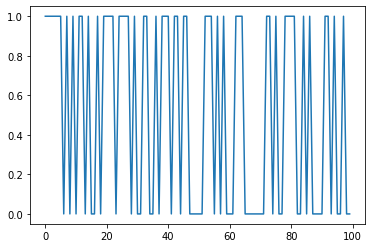

In [18]:
import matplotlib.pyplot as plt

plt.plot(history)

In [79]:
def cost1(params):
    state_squared.trace() + - np.dot(dephaser, circuit(params))